# Invert the TOV equations example for O$_2$sclpy

See the O$_2$sclpy documentation at
https://awsteiner.org/code/o2sclpy for more information.

Initial imports and setup for plotting and testing:

In [1]:
import o2sclpy
import matplotlib.pyplot as plot
import numpy
import sys
from tqdm import trange, tqdm

plots=True
if 'pytest' in sys.modules:
    plots=False

Get a copy (a pointer to) the O$_2$scl unit conversion object,
which also allows access to the constant library

In [2]:
o2scl_settings=o2sclpy.lib_settings_class()
cu=o2scl_settings.get_convert_units()

Get ħc.

In [3]:
ħc=cu.find_unique('hbarc','MeV*fm')
print('ħc = %7.6e\n' % (ħc))

ħc = 1.973270e+02



Use the cloud_file object to download the data file from Al-Mamun et al. (2021), which includes about 30,000 TOV solutions. This object only downloads the file once, and will just use the previously downloaded file on subsequent runs. This data file is the output of an MCMC simulation and autocorrelations have not been removed. 

In [4]:
cf=o2sclpy.cloud_file()
cf.verbose=1
cf.get_file_hash('tov_data.o2','https://isospin.roam.utk.edu/public_data/almamun21/4L_GW_all/nicer_fixp_4n24hr1_0_out',
                 '7463ed812ca1b64e16236ab69b24a24c0992f1db2c9c4983dc64fb0d69154a53')

Function cloud_file::get_file_hash() succeeded to obtain file named 'tov_data.o2'.


0

Read the O2scl table_units object from the file we downloaded:

In [5]:
hf=o2sclpy.hdf_file()
dat=o2sclpy.table_units()
hf.open('tov_data.o2')
o2sclpy.hdf_input_table(hf,dat,'')
hf.close()
N=dat.get_nlines()

This table has 1236 columns, but we won't need all of them. We print out some of the column names:

In [6]:
for i in range(0,dat.get_ncolumns()):
    if i<10 or i>dat.get_ncolumns()-11:
        print(i,dat.get_column_name(i))

0 b'rank'
1 b'thread'
2 b'walker'
3 b'mult'
4 b'log_wgt'
5 b'a'
6 b'alpha'
7 b'param_S'
8 b'param_L'
9 b'pres1'
1226 b'q6'
1227 b'Lambda_s'
1228 b'Lambda_a'
1229 b'Lambda_a_YY'
1230 b'C1'
1231 b'C2'
1232 b'tews_prob'
1233 b'ligo_prob'
1234 b'q'
1235 b'delta_m'


The EOSs stored in this data file are stored on a grid of energy densities. This is the energy density grid (in units of 1/fm^4):

In [7]:
elist=[0.3+(10.0-0.3)/99*i for i in range(0,100)]

The TOV solutions are stored on a grid of gravitational masses. This is the gravitational mass grid (in solar masses):

In [8]:
Mlist=[0.2+(3-0.2)/99*i for i in range(0,100)]

The pressures at each grid point defined in 'elist' are stored in columns named 'P_i', where 'i' goes from 1 to 100. We plot 40 rows of the data file, corresponding to 40 EOSs. (Note that there are some EOSs which have P=0 at high energy densities. This is a small bug but we'll fix it later.)

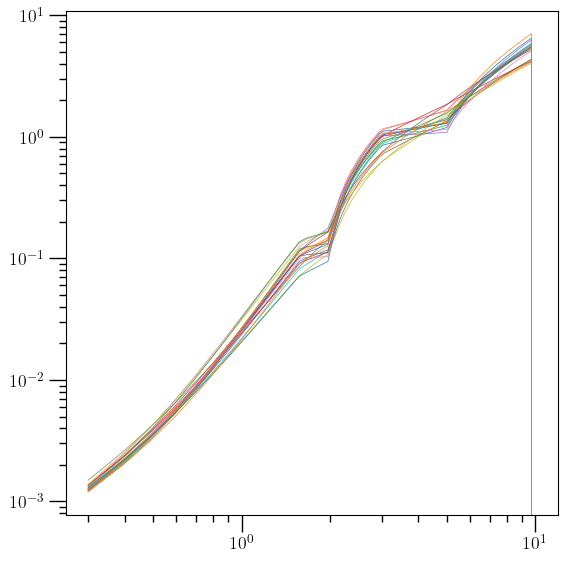

In [9]:
if plots:
    p=o2sclpy.plot_base()
    p.logx=True
    p.logy=True
    for j in range(0,N,N//40):
        Plist=[dat.get('P_'+str(k),j) for k in range(0,100)]
        p.plot([elist,Plist])
    p.show()

Similarly, the M-R curves are stored as radii in columns named 'R_i' over the gravitational mass grid stored in 'Mlist'. For gravitational masses larger than the maximum mass, the radius is reported in the data file as zero.

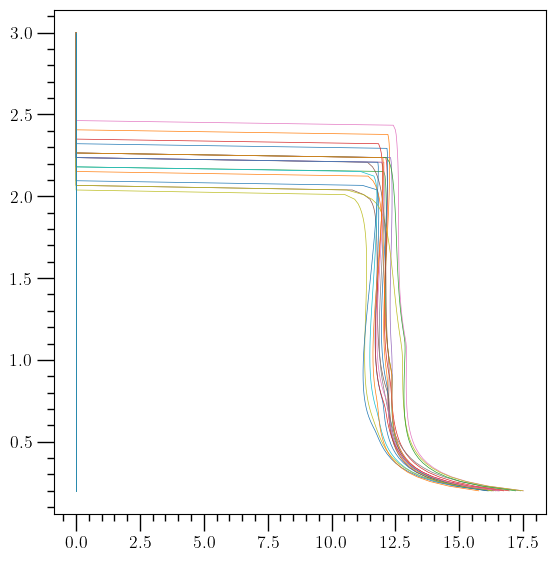

In [10]:
if plots:
    p=o2sclpy.plot_base()
    for j in range(0,N,N//40):
        Rlist=[dat.get('R_'+str(k),j) for k in range(0,100)]
        p.plot([Rlist,Mlist])
    p.show()

The way that this data is stored isn't great for the neural network. This function reinterpolates each row of the data file to ensure that the first entry is always the radius of a 1 solar mass neutron star, and the last entry is (approximately) the radius of the maximum mass star. This kind of data cleanup is frequently necessary. 

In [11]:
def reinterp(row,verbose=0):
    Rlist=[]
    if verbose>0:
        print('Mlist',Mlist)
    Mmax=dat.get('M_max',row)
    if verbose>0:
        print('Mmax:',Mmax)
    found=False
    # We truncate the maximum mass in order to prevent extrapolating the M-R curve 
    # from the data provided in the file. This means we won't have a 
    # precise description of the maximum mass.
    for j in range(0,100):
        if found==False and Mlist[j]<Mmax and Mmax<Mlist[j+1]:
            found=True
            Mmax=Mlist[j]
    if verbose>0:
        print('Mmax:',Mmax)
    for j in range(0,100):
        Rlist.append(dat.get('R_'+str(j),row))
    if verbose>0:
        print('Rlist:',Rlist)
    Rnew=[]
    for j in range(0,100):
        m=(Mmax-1.0)/99*j+1.0
        Rnew.append(numpy.interp(m,Mlist,Rlist))
    if verbose>0:
        print('Rnew:',Rnew)        
    return Rnew
    

Show how the function works, applied to the first row of the data table:

In [12]:
Rnew=reinterp(0,1)

Mlist [0.2, 0.22828282828282828, 0.25656565656565655, 0.28484848484848485, 0.31313131313131315, 0.3414141414141414, 0.3696969696969697, 0.397979797979798, 0.42626262626262623, 0.45454545454545453, 0.48282828282828283, 0.5111111111111111, 0.5393939393939393, 0.5676767676767677, 0.595959595959596, 0.6242424242424243, 0.6525252525252525, 0.6808080808080808, 0.709090909090909, 0.7373737373737375, 0.7656565656565657, 0.793939393939394, 0.8222222222222222, 0.8505050505050504, 0.8787878787878787, 0.9070707070707071, 0.9353535353535354, 0.9636363636363636, 0.9919191919191919, 1.02020202020202, 1.0484848484848484, 1.0767676767676768, 1.105050505050505, 1.1333333333333333, 1.1616161616161615, 1.1898989898989898, 1.218181818181818, 1.2464646464646463, 1.2747474747474747, 1.303030303030303, 1.3313131313131312, 1.3595959595959595, 1.3878787878787877, 1.416161616161616, 1.4444444444444444, 1.4727272727272727, 1.501010101010101, 1.5292929292929291, 1.5575757575757574, 1.5858585858585856, 1.6141414141

Apply this reinterpolation function to the entire data file, creating two-dimensional numpy arrays x2 and y2 which will be provided as the training data to the neural network. The "input", stored in x2, is the newly interpolated list of radii. The "output", stored in y2, is the pressure at each energy density grid point. In this example, there are 100 inputs and 100 outputs for each sample (essentially 100 functions of 100 variables), but the number of inputs and outputs does not need to match. 

In [13]:
if True:
    x2=numpy.zeros((N,100))
    y2=numpy.zeros((N,100))
    for i in trange(N):
        Rnew=reinterp(i)
        for j in range(0,100):
            x2[i,j]=Rnew[j]
            y2[i,j]=dat.get('P_'+str(j),i)

100%|██████████| 31358/31358 [00:42<00:00, 734.15it/s]


Create the simple TensorFlow-based neural network interpolator from O2sclpy. See https://awsteiner.org/code/o2sclpy/class_ml.html#o2sclpy.interpm_tf_dnn and https://github.com/awsteiner/o2sclpy/blob/main/o2sclpy/interpm.py#L901 . Then train the network for 800 epochs. We end early if the interpolation isn't getting any better. Even with a GPU, this takes a few minutes.  

In [14]:
if True:
    im=o2sclpy.interpm_tf_dnn()
    im.set_data(x2,y2,verbose=1,epochs=800,test_size=0.1,
    activations=['relu','relu','relu','relu'],
    hlayers=[200,400,400,200],transform_in='moto',
    transform_out='moto')

2025-06-13 03:43:29.048050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749786209.061148  294372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749786209.065267  294372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749786209.076872  294372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749786209.076892  294372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749786209.076894  294372 computation_placer.cc:177] computation placer alr

interpm_tf_dnn::set_data():
  outformat: numpy
  in_data shape: (31358, 100)
  out_data shape: (31358, 100)
  batch_size: None
  layers: [200, 400, 400, 200]
  activation functions: ['relu', 'relu', 'relu', 'relu']
  transform_in: moto
  transform_out: moto
  epochs: 800
  test_size: 0.1
min,max before transformation: 0.000000e+00 1.602342e-03
min,max after transformation : -1.000000e+00 1.000000e+00
nd_in,nd_out: 100 100
  Training DNN model.
Layer: dense 200 100 relu
Layer: dense 400 relu
Layer: dense 400 relu
Layer: dense 200 relu
Layer: dense 100 linear


I0000 00:00:1749786210.768781  294372 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1131 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:00:02.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        20,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,300 (1.38 MB)

 Trainable params: 361,300 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

summary: None
Epoch 1/800


I0000 00:00:1749786211.967825  294463 service.cc:152] XLA service 0x7e6bb000b830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749786211.967854  294463 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
I0000 00:00:1749786212.113709  294463 cuda_dnn.cc:529] Loaded cuDNN version 90501


131/882 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1174

I0000 00:00:1749786217.288461  294463 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


882/882 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0400 - val_loss: 0.0157
Epoch 2/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 3/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 4/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 5/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 6/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - val_loss: 0.0124
Epoch 7/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 8/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0133 - val_loss: 0.0123
Epoch 9/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 10/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 11/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 12/800
882/882 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/ste

Now we want to test our TOV inverter on an EOS it hasn't seen. We load the SLy4 Skyrme EOS:

In [15]:
sk=o2sclpy.eos_had_skyrme()
o2sclpy.skyrme_load(sk,'SLy4',False,0)

The o2scl nstar_cold object makes all of this easier. It automatically computes the EOS and solves the TOV equations. We put the EOS results in the table 'eos_table' and the TOV results in 'tov_table'.

In [16]:
nc=o2sclpy.nstar_cold()
nc.set_eos(sk)
nc.calc_eos(0.01)
eos_table=nc.get_eos_results()
print(eos_table.get_unit('ed'),eos_table.get_unit('pr'))
nc.calc_nstar()
tov_table=nc.get_tov_results()

b'1/fm^4' b'1/fm^4'
Mass versus radius mode.
Central P: 7.0000e-07 (Msun/km^3), M: 1.0059e-01 (Msun), R: 8.2868e+01 (km)
Central P: 7.7000e-07 (Msun/km^3), M: 1.0337e-01 (Msun), R: 6.4040e+01 (km)
Central P: 8.4700e-07 (Msun/km^3), M: 1.0681e-01 (Msun), R: 5.1639e+01 (km)
Central P: 9.3170e-07 (Msun/km^3), M: 1.1085e-01 (Msun), R: 4.3052e+01 (km)
Central P: 1.0249e-06 (Msun/km^3), M: 1.1550e-01 (Msun), R: 3.6810e+01 (km)
Central P: 1.1274e-06 (Msun/km^3), M: 1.2075e-01 (Msun), R: 3.2147e+01 (km)
Central P: 1.2401e-06 (Msun/km^3), M: 1.2664e-01 (Msun), R: 2.8559e+01 (km)
Central P: 1.3641e-06 (Msun/km^3), M: 1.3317e-01 (Msun), R: 2.5742e+01 (km)
Central P: 1.5005e-06 (Msun/km^3), M: 1.4036e-01 (Msun), R: 2.3493e+01 (km)
Central P: 1.6506e-06 (Msun/km^3), M: 1.4826e-01 (Msun), R: 2.1669e+01 (km)
Central P: 1.8156e-06 (Msun/km^3), M: 1.5689e-01 (Msun), R: 2.0173e+01 (km)
Central P: 1.9972e-06 (Msun/km^3), M: 1.6629e-01 (Msun), R: 1.8932e+01 (km)
Central P: 2.1969e-06 (Msun/km^3), M: 1.765

Plot the full M-R curve:

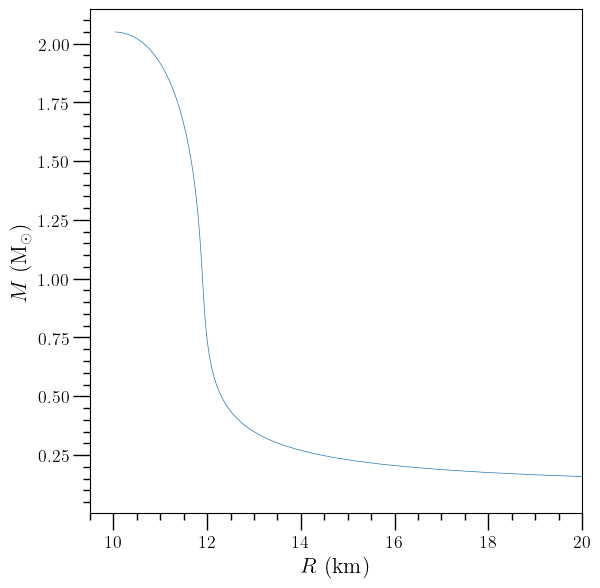

In [17]:
if plots:
    p=o2sclpy.plot_base()
    p.xlimits(9.5,20)
    p.plot([tov_table,'r','gm'])
    p.xtitle(r'$ R~(\mathrm{km}) $')
    p.ytitle(r'$ M~(\mathrm{M}_{\odot}) $')
    p.show()

Plot the Skyrme SLy4 EOS alone (without the inverter):

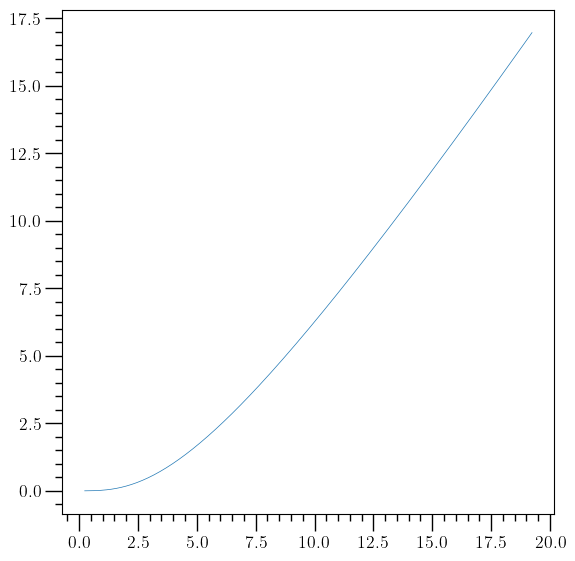

In [18]:
if plots:
    p=o2sclpy.plot_base()
    p.plot([eos_table,'ed','pr'])
    p.show()

We need the maximum mass to reinterpolate the M-R curve into the format used by the neural network inverter:

In [19]:
Mmax=tov_table.max('gm')
print(Mmax)

2.0501253392244285


Perform the reinterpolation for the SLy4 M-R curve:

In [20]:
tov_table.set_interp_type(o2sclpy.itp_linear)
Rnew=[]
for j in range(0,100):
    m=(Mmax-1.0)/99*j+1.0
    Rnew.append(tov_table.interp('gm',m,'r'))
print(Rnew)

[11.90021496060563, 11.897043504522365, 11.89387109384384, 11.890698683165317, 11.887526272486793, 11.884298433587254, 11.880986619675422, 11.877674805763592, 11.87436299185176, 11.871051177939927, 11.867533491480364, 11.863976011900315, 11.860418532320267, 11.856861052740218, 11.853220801415564, 11.849306828854655, 11.845392856293746, 11.841478883732838, 11.83756491117193, 11.83338657992025, 11.829029077372718, 11.824671574825187, 11.820314072277656, 11.815956569730123, 11.81109105154843, 11.806196569931249, 11.801302088314067, 11.796407606696887, 11.791325970620782, 11.785806828862349, 11.780287687103913, 11.774768545345477, 11.769249403587041, 11.763248661908928, 11.757015272627656, 11.750781883346384, 11.74454849406511, 11.738243979286638, 11.731206983558273, 11.724169987829908, 11.717132992101545, 11.71009599637318, 11.70255437283702, 11.694617025738944, 11.686679678640871, 11.678742331542797, 11.670696296912231, 11.661756882189685, 11.652817467467141, 11.643878052744595, 11.63493

Place the exact EOS in 'Pexact', and the neural network inverter's estimate in 'Pnn'. Note this is a lot faster than training.

In [21]:
Pnn=im.eval(numpy.array(Rnew))
eos_table.set_interp_type(o2sclpy.itp_linear)
Pexact=[eos_table.interp('ed',elist[i],'pr') for i in range(0,100)]

Compare the result. The blue is the exact EOS and the orange is the EOS from the inverter. The drop in the pressure at high energy densities is an artifact of the aforementioned bugs in the data file.

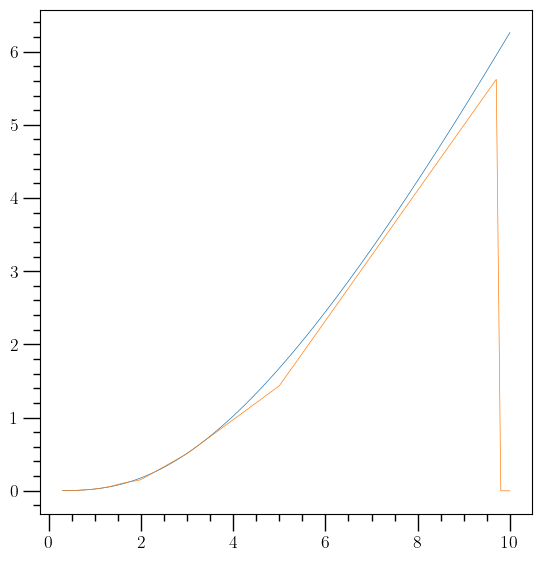

In [22]:
if plots:
    p=o2sclpy.plot_base()
    p.plot([elist,Pexact])
    p.plot([elist,Pnn])
    p.show()

It would be easy to improve this using more training data, optimizing the network, and being a bit more careful about the reinterpolation which needs to be done. The accuracy of this inverter depends critically on a chance observation of the radius of the maximum mass star. 